In [1]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os
import random
import math
import matplotlib.pyplot as plt
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).

    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance

    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.

    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.

    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).

     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/" # "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

## Network constituent functions

In [2]:
def sigmoid(values: list):
    """ Sigmoid for vectors"""
    return 1/(1 + np.exp(-values))

def softmax(values: list):
    """ Softmax for vectors"""
    exp_values = np.exp(values - np.max(values, axis=1, keepdims=True)) # substracting max for numerical stability 
    return exp_values/np.sum(exp_values, axis = -1, keepdims = True)

def get_loss(predictions, targets):
    """ Calculate loss of current prediction """
    batch_size = predictions.shape[0]
    # epsilon = 1e-12 # buffer to prevent overflow
    loss = np.sum(-np.log(predictions[np.arange(batch_size), targets])) 
    return  loss / batch_size


def deriv_sigmoid(values: list):
    """ Derivative of sigmoid for vectors """
    sigmoid_vals = sigmoid(values)
    return sigmoid_vals*(1 - sigmoid_vals)


def deriv_cross_softmax(pred, target):
    """ Cross_softmax derivative for Tensors"""
    grad = np.copy(pred) 
    batch_size = pred.shape[0]
    grad[np.arange(batch_size), target] -= 1 # adjust gradient for target
    return grad/batch_size
    
def forwardpass(input, w1, b1, w2, b2):
    """ Feedforward pass with Tensor implementation using batches"""
    # feedforward pass

        # (batch_size, n_hidden)
    O1 = np.matmul(input, w1) + b1 # first line of linear combination

        # (batch_size, n_hidden)
    H = sigmoid(O1) # sigmoid activation function

        # (batch_size, output)
    O2 = np.matmul(H, w2) + b2 # second linear combination

        # (batch_size, output)
    Y = softmax(O2) # sigmoid activation function

    return O1, H, O2, Y

def backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y):
    """ Backpropagation with Tensor implementation using batches"""
    #compute loss
    loss = get_loss(Y, target)

    # backwards pass to compute derivatives

        # (batch_size, output)
    dL_do2 = deriv_cross_softmax(Y, target) # deriv. of loss with rep. to the softmax output
    
        # (n_hidden, output)
    dL_dw2 = np.matmul(H.T, dL_do2)# deriv. of the loss with respect to w2
    
        # (output, )
    dL_db2 = np.sum(dL_do2, axis = 0) # deriv. of the loss with respect to b2
    
        # (batch_size, n_hidden)
    dL_dh = np.matmul(dL_do2, w2.T) # deriv. of the loss with respect to the sigmoid output
    
        #(batch_size, n_hidden)
    dL_do1 = dL_dh * deriv_sigmoid(O1) # deriv. of the loss with respect to the first linear comb.
    
        # (input, n_hidden)
    dL_dw1 = np.matmul(input.T, dL_do1) # deriv. of the loss with respects to w1
    
        # (n_hidden, )
    dL_db1 = np.sum(dL_do1, axis = 0) # deriv. of the loss with respects to b1
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss


def forward_and_backward(input, w1, b1, w2, b2, target):
    # feedforward pass
    O1, H, O2, Y = forwardpass(input, w1, b1, w2, b2)

    # backwards pass and get derivatives
    dL_dw1, dL_db1, dL_dw2, dL_db2, loss = backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha):
    # update weights and biases
    w1 -= alpha * dL_dw1
    b1 -= alpha * dL_db1
    w2 -= alpha * dL_dw2
    b2 -= alpha * dL_db2

    return w1, b1, w2, b2

## Training and plotting functions

In [17]:
# Training and plotting functions 
def plot_loss(train_loss, val_loss):
    """ Plot avg and epoch Loss """
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label = "Training Loss", linestyle = "--", color = "blue")
    plt.plot(val_loss, label = "Validation Loss", linestyle = "-", color = "green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

def batch_train(train, valid, w1, b1, w2, b2, alpha, max_epoch, batch_size):
    xtrain, ytrain = train 
    xvalid, yvalid = valid
    avg_loss = []
    val_loss = []

    for epoch in range(max_epoch):
    # start training in current epoch
        train_loss = 0
        
        # training 
        for iter in range(0, len(xtrain), batch_size):
            
            # get batch for current iteration 
            xbatch = xtrain[iter : batch_size + iter]
            ybatch = ytrain[iter : batch_size + iter]
            
            # compute forwards and backwards pass to get derivatives and loss 
            dL_dw1, dL_db1, dL_dw2, dL_db2,  loss = forward_and_backward(xbatch, w1, b1, w2, b2, ybatch)

            # aggregate loss 
            train_loss += loss

            # update weights through gradient descent 
            w1, b1, w2, b2 = gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha)    
           
        # calculate the avg loss of training
        avg_loss.append(train_loss / (len(xtrain) / batch_size))

        # validation pass 
        _, _, _, y = forwardpass(xvalid, w1, b1, w2, b2)
        val_loss.append(get_loss(y, yvalid))

        # randomize dataset
        indices = np.arange(len(xtrain))
        xtrain = np.array([xtrain[i] for i in indices])
        ytrain = np.array([ytrain[i] for i in indices])
    
    # plot_loss(avg_loss, val_loss)

    return avg_loss, val_loss

In [4]:
# load data
(xtrain, ytrain), (xvalid, yvalid), n_class = load_mnist(flatten=True)

## Experiments

In [32]:
# primary experiment setups 
def init_weights():
    # initialization of weights
    w1 = np.random.randn(input_size, hidden_layer)
    b1 = np.zeros(hidden_layer)
    w2 = np.random.randn(hidden_layer, output_size)
    b2 = np.zeros(output_size)
    return w1, b1, w2, b2

# setting for network
hidden_layer = 300
input_size = xtrain.shape[1]
output_size = 10

# normalizing data
xtrain_norm = xtrain/255.0
xvalid_norm = xvalid/255.0

# data 
train = (xtrain_norm, ytrain)
valid = (xvalid_norm, yvalid)


### Experiment 1

Training loss vs Validation loss

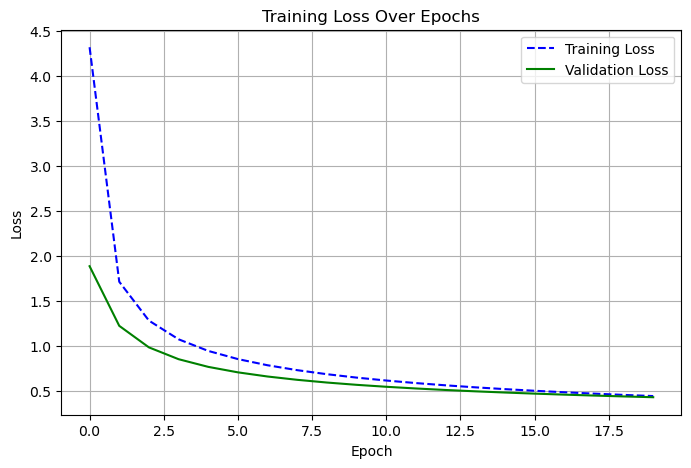

In [ ]:
# initialization of weights
w1, b1, w2, b2 = init_weights()

# train model hyperparameters
alpha = 0.02
epochs = 20
batch_size = 64

# run experiment 1
train_loss, val_loss = batch_train(train, valid, w1, b1, w2, b2, alpha, epochs, batch_size)
plot_loss(train_loss, val_loss)

## Experiment 2

Different weight initializations

In [44]:
## support function for data preparation for plotting 
def get_avg_and_sd(training_log: list):
    """Get the average values over a set of logs"""
    average = []
    std = []
    # Loop over the number of generations in a run
    for gen in range(len(training_log[0])):
        # get gen scores per run
        gen_scores = []
        # Loop over the runs 
        for run in range(len(training_log)):
            gen_scores.append(training_log[run][gen])
        # get average per
        average.append(np.mean(gen_scores))
        std.append(np.std(gen_scores))

    return average, std 
    
def plot_lines(ea1_mean, ea1_std, ea2_mean, ea2_std, labels):
    fig, axes = plt.subplots(1, 1, figsize =(10, 6))

    ### plotting best line
    axes.plot(ea1_mean, linestyle='-', label=labels[0], color="green") # plot data point
    # add sd around line 
    axes.fill_between(
        np.arange(len(ea1_mean)),
        np.array(ea1_mean) - np.array(ea1_std),
        np.array(ea1_mean) + np.array(ea1_std),
        alpha = 0.3,
        color="green"
    )
    ### plotting average line 
    axes.plot(ea2_mean, linestyle = "-", label=labels[1], color="blue") # plot data point
    # add sd around line 
    axes.fill_between(
        np.arange(len(ea2_mean)),
        np.array(ea2_mean) - np.array(ea2_std),
        np.array(ea2_mean) + np.array(ea2_std),
        alpha = 0.3,
        color="blue"
    )

    axes.set_title(f"Training Loss vs Validation loss with {labels[2]} random weight initializations")
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend(loc="upper left")


    plt.tight_layout()
    
    plt.show()

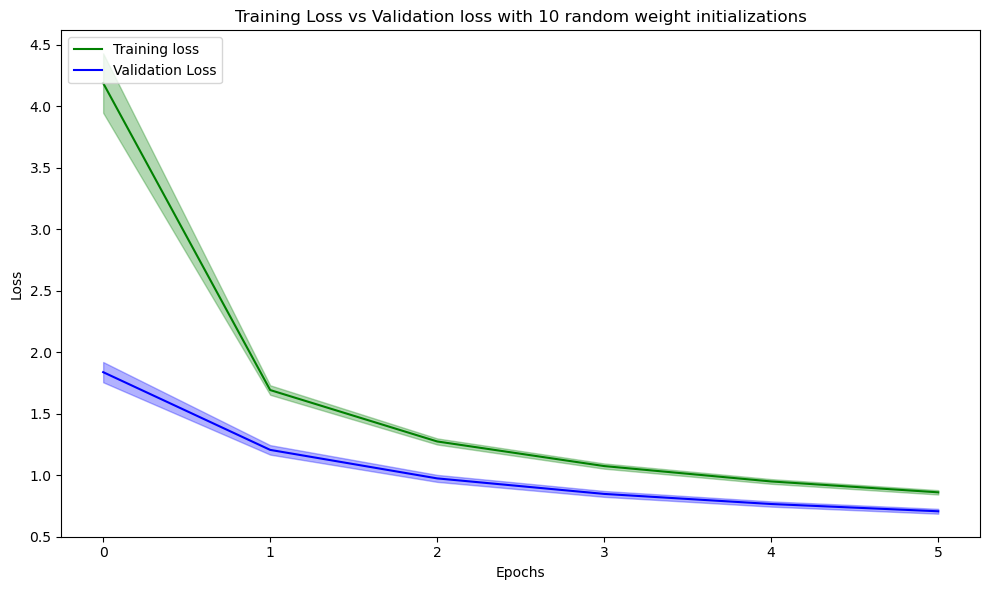

In [45]:
# train model hyperparameters
alpha = 0.02
epochs = 6
batch_size = 64
num_runs = 10  # Number of random initializations

# Store the training and validation loss values from each run
all_train_losses = np.zeros((num_runs, epochs))
all_val_losses = np.zeros((num_runs, epochs))

# Train the network multiple times
for run in range(num_runs):
    # new inits per run
    w1, b1, w2, b2 = init_weights()
    train_loss, val_loss = batch_train(train, valid, w1, b1, w2, b2, alpha, epochs, batch_size)
    all_train_losses[run] = train_loss
    all_val_losses[run] = val_loss

# get mean and std
avg_train, sd_train = get_avg_and_sd(all_train_losses)
avg_val, sd_val = get_avg_and_sd(all_val_losses)

labels = ["Training loss", "Validation Loss", num_runs]

plot_lines(avg_train, sd_train, avg_val, sd_val, labels)

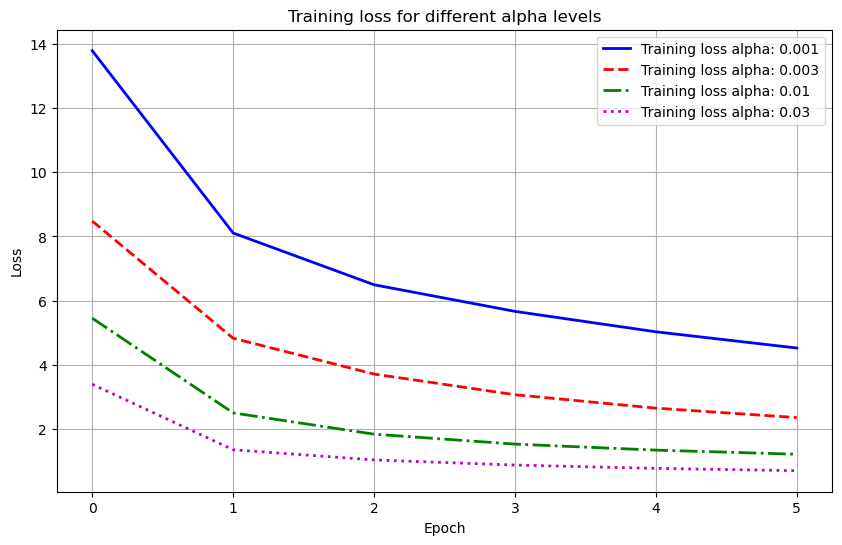

In [46]:
# train model hyperparameters
alpha = [0.001, 0.003, 0.01, 0.03]
epochs = 6
batch_size = 64
num_runs = 4  # Number of random initializations

# Store the training and validation loss values from each run
all_train_losses = np.zeros((num_runs, epochs))
all_val_losses = np.zeros((num_runs, epochs))

# Train the network multiple times
for run in range(num_runs):
    w1, b1, w2, b2 = init_weights()
    train_loss, val_loss = batch_train(train, valid, w1, b1, w2, b2, alpha[run], epochs, batch_size)
    all_train_losses[run] = train_loss
    all_val_losses[run] = val_loss

# ploting details
colors = ["blue", "red", "green", "m"]
linestyle = ["-", "--", "-.", ":"]

# generate plot 
plt.figure(figsize=(10, 6))

for run in range(num_runs):
    # Plot the training loss
    plt.plot(all_train_losses[run], label=f'Training loss alpha: {alpha[run]}', linestyle = linestyle[run],  lw=2, color=colors[run])

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training loss for different alpha levels')
plt.legend()
plt.grid(True)
plt.show()